In [1]:
!pip install -q kaggle

In [3]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download andradaolteanu/gtzan-dataset-music-genre-classification

Dataset URL: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification
License(s): other
 99% 1.20G/1.21G [00:08<00:00, 169MB/s]
100% 1.21G/1.21G [00:08<00:00, 152MB/s]


In [ ]:
! unzip /content/gtzan-dataset-music-genre-classification.zip

In [9]:
pip install np_utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 760.7 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [45]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import os
from tqdm import tqdm
import librosa
from skimage.transform import resize
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers

In [22]:
# Load data
data_dir = "/content/Data/genres_original"


genres = os.listdir(data_dir)
num_samples_per_genre = 100
audio_data = []
labels = []

# Define target size for spectrogram
target_height = 128
target_width = 128

for genre in genres:
    genre_dir = os.path.join(data_dir, genre)
    for filename in tqdm(os.listdir(genre_dir)[:num_samples_per_genre]):
        file_path = os.path.join(genre_dir, filename)
        try:
            signal, sr = librosa.load(file_path, sr=None)
            mel_spec = librosa.feature.melspectrogram(y=signal, sr=sr)
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
            mel_spec_db_resized = resize(mel_spec_db, (target_height, target_width), anti_aliasing=True)
            mel_spec_db_resized = mel_spec_db_resized[..., np.newaxis]  # Add channel dimension
            audio_data.append(mel_spec_db_resized)
            labels.append(genre)
        except Exception as e:
            print(f"Error loading {file_path}: {str(e)}")



  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-22-95e55a3d94d4>:19: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sr = librosa.load(file_path, sr=None)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  3%|▎         | 3/100 [00:00<00:11,  8.72it/s]

Error loading /content/Data/genres_original/jazz/jazz.00054.wav: 


100%|██████████| 100/100 [00:11<00:00,  8.48it/s]


In [23]:
audio_data = np.array(audio_data)
labels = np.array(labels)

In [25]:
labelencoder = LabelEncoder()
labels = labelencoder.fit_transform(labels)
len(labelencoder.classes_)

10

In [33]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(audio_data, labels, test_size=0.2, random_state=42)


In [39]:
len(np.unique(y_train))

10

In [44]:
# Build CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(target_height, target_width, 1)),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(10, activation='softmax')
])

# Compile model
adam = optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=adam,

              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()
# Train model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization_5 (Bat  (None, 62, 62, 32)        128       
 chNormalization)                                                
                                                                 
 flatten_5 (Flatten)         (None, 123008)            0         
                                                                 
 dense_10 (Dense)            (None, 10)                1230090   
                                                                 
Total params: 1230538 (4.69 MB)
Trainable params: 1230

In [60]:
def plot_history(hist, accuracy=True):
    plt.figure()
    fig, axs = plt.subplots(1)
    if(accuracy):
       # accuracy subplot
       axs.plot(hist.history["accuracy"], label="train accuracy")
       axs.plot(hist.history["val_accuracy"], label="test accuracy")
       axs.set_ylabel("Accuracy")
       axs.legend(loc="lower right")
       axs.set_title("Accuracy eval")
    else:
       # Error subplot
       axs.plot(hist.history["loss"], label="train error")
       axs.plot(hist.history["val_loss"], label="test error")
       axs.set_ylabel("Error")
       axs.set_xlabel("Epoch")
       axs.legend(loc="upper right")
       axs.set_title("Error eval")

    plt.show()

In [58]:
# Retrieve training and validation accuracy
train_accuracy = history.history['accuracy'][-1]  # Last epoch accuracy
test_accuracy = history.history['val_accuracy'][-1]  # Last epoch validation accuracy

# Print accuracies
print('Training accuracy:', train_accuracy)
print('Test accuracy:', test_accuracy)


Training accuracy: 1.0
Test accuracy: 0.6800000071525574


<Figure size 640x480 with 0 Axes>

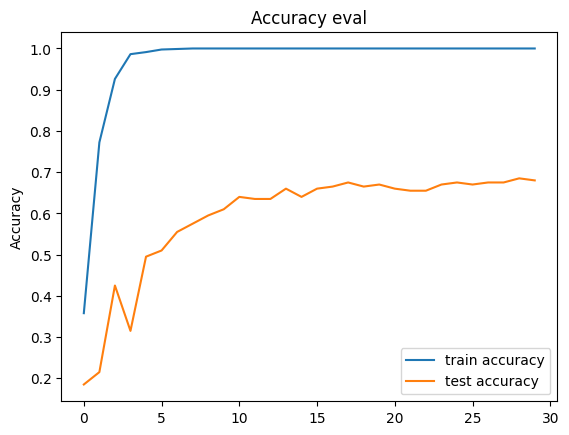

In [61]:
plot_history(history)

<Figure size 640x480 with 0 Axes>

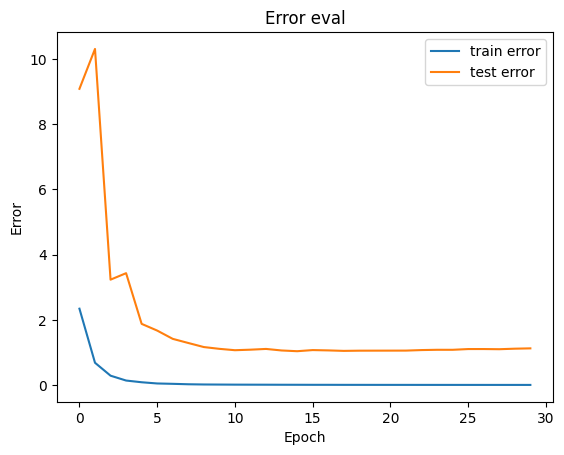

In [63]:
plot_history(history,accuracy=False)

In [65]:
from sklearn.metrics import classification_report, accuracy_score
# Predict classes
y_pred = np.argmax(model.predict(X_test), axis=-1)

# Classification report
report = classification_report(y_test, y_pred, target_names=genres)
print(report)

7/7 [==============================] - 1s 151ms/step
              precision    recall  f1-score   support

       blues       0.73      0.52      0.61        21
     country       0.78      0.90      0.84        20
        jazz       0.42      0.83      0.56        12
       disco       0.58      0.61      0.60        23
       metal       0.94      0.73      0.82        22
        rock       0.88      0.61      0.72        23
         pop       0.71      1.00      0.83        15
      reggae       0.62      0.83      0.71        18
      hiphop       0.68      0.68      0.68        19
   classical       0.59      0.37      0.45        27

    accuracy                           0.68       200
   macro avg       0.69      0.71      0.68       200
weighted avg       0.71      0.68      0.68       200

